In [6]:
import pickle
from os import path, mkdir

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import Rbf
from sklearn.model_selection import train_test_split

from localization import utils, dataset
from localization.models.rbf_model import Model

In [3]:
utils.make_deterministic(33)

def radial_log_basis_function(model, r):
    return np.log(r + model.epsilon)

Rbf.radial_log_basis_function = radial_log_basis_function
with open('output/filtered_model.bin', 'rb') as inp:
    model: Model = pickle.load(inp)


In [9]:
num_buildings = 3
num_floors_in_each_building = {0: 4,
                               1: 4,
                               2: 5}

sigma = 6.75
num_samples = 2
new_samples = 1_000_000
batch_size = 10_000

rng = np.random.default_rng(33)

data_dir = "data/generated-sample-5/"

In [ ]:
data = dataset.load_ujiindoor_loc(data_folder='data/filtered')
routers = model.get_all_routers_in_this_floor(data.get_full_df().columns)

### Generation based on RBF $\mu$ and $\phi$

In [5]:
# generated_data = pd.DataFrame(columns=data.get_full_df().columns)

b = rng.integers(0, num_buildings, size=new_samples)
f = np.array([rng.integers(0, num_floors_in_each_building[building]) for building in b])
idxs = [rng.integers(0, len(model.x_building[building])) for building in b]
x = model.x_building[[b, idxs]]
y = model.y_building[[b, idxs]]
# x = np.array([rng.uniform(model.x_building[building][0], model.x_building[building][-1]) for building in b])
# y = np.array([rng.uniform(model.y_building[building][0], model.y_building[building][-1]) for building in b])

gen_data = {r: [] for r in routers}
for i in range(new_samples):
    for r in routers:
        if r in model.mu_rbf[b[i]][f[i]]:
            mu = model.mu_rbf[b[i]][f[i]][r](x[i], y[i])
            phi = np.minimum(model.phi_rbf[b[i]][f[i]][r](x[i], y[i]), 1)
            gen_data[r].append(rng.normal(mu, sigma) * rng.binomial(1, phi))
        else:
            gen_data[r].append(np.nan)

for r in routers:
    gen_data[r] = np.array(gen_data[r])

gen_data["BUILDINGID"] = b
gen_data["FLOOR"] = f
# gen_data["SPACEID"] = -np.ones(num_samples)
# gen_data["RELATIVEPOSITION"] = -np.ones(num_samples)
# gen_data["USERID"] = -np.ones(num_samples)
# gen_data["PHONEID"] = -np.ones(num_samples)
# gen_data["TIMESTAMP"] = -np.ones(num_samples)
# gen_data["LATITUDE"] = -np.ones(num_samples)
# gen_data["LONGITUDE"] = -np.ones(num_samples)
gen_data["x"] = x
gen_data["y"] = y
generated_data = pd.DataFrame(gen_data)

In [9]:
generated_data = generated_data.fillna(0.0)
generated_data = generated_data.clip(lower=0)
generated_data.sample(10)

,WAP001,WAP002,WAP007,WAP008,WAP009,WAP013,WAP014,WAP017,WAP018,WAP019,...,WAP512,WAP513,WAP514,WAP516,WAP517,WAP518,BUILDINGID,FLOOR,x,y
6266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,2,0,65.01486,0.0
4235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,2,1,65.01486,0.0
4434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,1,1,65.01486,0.0
89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,65.01486,0.0
3436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,3,65.01486,0.0
9033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,65.01486,0.0
9160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,1,0,65.01486,0.0
2954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,1,3,65.01486,0.0
4665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,2,3,65.01486,0.0
9411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,28.289112,0.0,0.0,2,1,65.01486,0.0


In [10]:
train_df, test_df = train_test_split(generated_data, test_size=0.2)

In [ ]:
train_df.to_csv('data/generated2/trainingData.csv', index=False)
test_df.to_csv('data/generated2/validationData.csv', index=False)

In [ ]:
train_df = pd.read_csv

### Generation based on RBF $\mu$ and $\phi$ - batched

In [7]:
generated_data = pd.DataFrame(columns=routers+["BUILDINGID", "FLOOR", "x", "y"]+["LATITUDE", "LONGITUDE"])
if not path.exists(data_dir): mkdir(data_dir)
generated_data.to_csv(f'{data_dir}/trainingData.csv', index=False)
generated_data.to_csv(f'{data_dir}/validationData.csv', index=False)

In [8]:
num_batches = new_samples // batch_size

for _ in tqdm(range(num_batches)):
    b = rng.integers(0, num_buildings, size=batch_size)
    f = np.array([rng.integers(0, num_floors_in_each_building[building]) for building in b])
    idxs = [rng.integers(0, len(model.x_building[building])) for building in b]
    x = np.array([model.x_building[building][idx] for (building, idx) in zip(b, idxs)])
    y = np.array([model.y_building[building][idx] for (building, idx) in zip(b, idxs)])
    # x = np.array([rng.uniform(model.x_building[building][0], model.x_building[building][-1]) for building in b])
    # y = np.array([rng.uniform(model.y_building[building][0], model.y_building[building][-1]) for building in b])

    gen_data = {r: [] for r in routers}
    for i in range(batch_size):
        for r in routers:
            if r in model.mu_rbf[b[i]][f[i]]:
                mu = model.mu_rbf[b[i]][f[i]][r](x[i], y[i])
                phi = np.minimum(model.phi_rbf[b[i]][f[i]][r](x[i], y[i]), 1)
                gen_data[r].append(rng.normal(mu, sigma) * rng.binomial(1, phi))
            else:
                gen_data[r].append(np.nan)

    for r in gen_data:
        gen_data[r] = np.array(gen_data[r])

    gen_data.update({
        "BUILDINGID": b,
        "FLOOR": f,
        # "SPACEID": -1 * np.ones(batch_size),
        # "RELATIVEPOSITION": -1 * np.ones(batch_size),
        # "USERID": -1 * np.ones(batch_size),
        # "PHONEID": -1 * np.ones(batch_size),
        # "TIMESTAMP": -1 * np.ones(batch_size),
        "LATITUDE": -1 * np.ones(batch_size),
        "LONGITUDE": -1 * np.ones(batch_size),
        "x": x,
        "y": y
    })
    generated_data = pd.DataFrame(gen_data)
    generated_data = generated_data.fillna(0.0)
    generated_data = generated_data.clip(lower=0)
    train_df, test_df = train_test_split(generated_data, test_size=0.1)

    train_df.to_csv(f'{data_dir}/trainingData.csv', index=False, mode='a', header=False)
    test_df.to_csv(f'{data_dir}/validationData.csv', index=False, mode='a', header=False)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [05:55<00:00, 35.55s/it]


### Generation based on already calculated points ($\mu_b$ and $\phi_b$)

In [ ]:
generated_data = pd.DataFrame(columns=data.get_full_df().columns)

for building in range(num_buildings):
    for floor in tqdm(range(model.num_floors_in_each_building[building])):
        filtered_dataset = data.get_floor_data(building=building, floor=floor)
        X_train = filtered_dataset.get_full_df()
        routers = model.get_all_routers_in_this_floor(X_train.columns)
        gen_data = {}

        for router in routers:
            if model.checking_non_null_minimum_percentage_of_samples(X_train, router):
                # X_train = model.get_mu_and_phi_estimation(X_train, router)
                phi_building = model.phi_rbf[building][floor][router]
                phi_building = np.where(phi_building > 1, 1, phi_building)
                mu_building = model.mu_rbf[building][floor][router]

                gen_data[router] = np.random.normal(np.tile(mu_building, num_samples), sigma) * \
                                          np.random.binomial(1, np.tile(phi_building, num_samples))

            # print(gen_data[router])
            # print(gen_data[router].shape)

        # first router of third building of first floor has a different shape
        if building == 2 and floor == 0:
            max_length = max(len(arr) for arr in gen_data.values())
            for key in gen_data:
                if len(gen_data[key]) < max_length:
                    gen_data[key] = np.pad(gen_data[key], (0, max_length - len(gen_data[key])), constant_values=0)

        # get the right values
        gen_data = pd.DataFrame(gen_data)
        # print(generated_data.shape, gen_data.shape)
        gen_data.loc[:, "BUILDINGID"] = [building] * gen_data.shape[0]
        gen_data.loc[:, "FLOOR"] = [floor] * gen_data.shape[0]
        gen_data.loc[:, "SPACEID"] = [0] * gen_data.shape[0]
        gen_data.loc[:, "RELATIVEPOSITION"] = [0] * gen_data.shape[0]
        gen_data.loc[:, "USERID"] = [-1] * gen_data.shape[0]
        gen_data.loc[:, "PHONEID"] = [-1] * gen_data.shape[0]
        gen_data.loc[:, "TIMESTAMP"] = [-1] * gen_data.shape[0]
        gen_data.loc[:, "LATITUDE"] = [0] * gen_data.shape[0]
        gen_data.loc[:, "LONGITUDE"] = [0] * gen_data.shape[0]
        gen_data.loc[:, "x"] = np.tile(model.x_building[building], num_samples)
        gen_data.loc[:, "y"] = np.tile(model.y_building[building], num_samples)
        generated_data = pd.concat([generated_data, pd.DataFrame(gen_data)], ignore_index=True)

100%|██████████| 5/5 [00:35<00:00,  7.18s/it]


In [ ]:
generated_data = generated_data.fillna(0.0)
generated_data = generated_data.clip(lower=0)
generated_data.sample(10)

,WAP001,WAP002,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,...,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,x,y
20769,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0,1,1,0,0,0,0,0,0.000000,10.356031
41120,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,7.665740,14.533680,...,0,1,2,0,0,0,0,0,0.636560,0.000000
28798,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0,2,1,0,0,0,0,0,0.000000,0.000000
26655,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0,2,1,0,0,0,0,0,0.000000,28.898784
37325,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0,0,2,0,0,0,0,0,0.000000,4.143140
48268,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,3.581022,17.183868,...,0,2,2,0,0,0,0,0,0.636560,34.761567
44526,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,8.516054,32.029452,...,0,1,2,0,0,0,0,0,0.000000,0.000000
38978,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0,0,2,0,0,0,0,0,15.385154,0.000000
16829,0.0,0.0,0.0,7.754054,0.0,12.717207,0.0,0.0,0.000000,0.000000,...,0,0,1,0,0,0,0,0,17.879972,0.000000
50731,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.173060,0.000000,...,0,2,2,0,0,0,0,0,0.000000,31.845526


In [ ]:
train_df, test_df = train_test_split(generated_data, test_size=0.2)

In [ ]:
train_df.to_csv('data/generated/trainingData.csv', index=False)
test_df.to_csv('data/generated/validationData.csv', index=False)

: 

In [ ]:
generated_data

### Generation based on probs

In [41]:
from localization.augmentation.augmentation_rbf_model import Augmentation
import pickle
from os import path, mkdir
import pandas as pd
from localization.dataset.ujiindoorloc import calculate_means

In [5]:
def train_test_split_random(df, test_size=0.5):
    """Randomly split DataFrame into train/test sets."""
    val_df = df[df.shape[0] // 2:]
    train_df = df[:df.shape[0] // 2]   
    return train_df, val_df

In [7]:
df = pd.read_csv('data/filtered/validationData.csv')
routers = df.columns[:-9]
augmenter = Augmentation(model, routers)
augmented_df = augmenter.generate_augmented_data(num_samples_per_floor=5000)

In [8]:
augmented_df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,x,y,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.339002,6.227420,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.339002,21.149308,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,25.899157,8.940490,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-14.781307,6.227420,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,...,0.0,-11.767939,-0.555257,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-18.536613,-62.925796,4,2,0,0,0,0,0
64996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,25.709171,-27.933308,4,2,0,0,0,0,0
64997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,40.457765,-27.933308,4,2,0,0,0,0,0
64998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.960576,23.097404,4,2,0,0,0,0,0


In [ ]:
if not path.exists('data/augmented_probs'): mkdir('data/augmented_probs')

train_df, val_df = train_test_split_random(augmented_df)

# Save augmented data

train_df['LATITUDE'] = train_df['x']
train_df['LONGITUDE'] = train_df['y']
val_df['LATITUDE'] = val_df['x']
val_df['LONGITUDE'] = val_df['y']

train_df.to_csv("data/augmented_probs/trainingData.csv", index=False)
val_df.to_csv("data/augmented_probs/validationData.csv", index=False)

In [12]:
train_df.to_csv("data/augmented_probs/trainingData.csv", index=False)
val_df.to_csv("data/augmented_probs/validationData.csv", index=False)

In [11]:
train_df['LATITUDE']

0        12.339002
1        12.339002
2        25.899157
3       -14.781307
4       -11.767939
           ...    
32495   -32.880677
32496   -43.757959
32497    -2.061711
32498    -3.874592
32499    23.318613
Name: LATITUDE, Length: 32500, dtype: float64

In [ ]:
p_xy = 1/model.power_probability_masks[0][0]['WAP007'][0].shape[0]
probs = []
for p in range(106):
    p_p = model.power_prior_probability_distribution[0][0]['WAP007'][p]
    p_xy_given_bfrp = model.power_probability_masks[0][0]['WAP007'][p]
    p_p_given_bfrxy = p_xy_given_bfrp *  p_p / p_xy
    probs.append(p_p_given_bfrxy)

probs = np.array(probs)

In [ ]:
print(probs.shape)
print(probs[:][0].shape)

In [ ]:
np.random.choice(106, 20, p=probs[:,0]/probs[:,0].sum())

In [ ]:
data = dataset.load_ujiindoor_loc(data_folder='data')
data_fil = data.get_floor_data(building=0, floor=0, reset_means=True)

x_building, y_building = model.construct_building_map(data_fil, 0)

In [ ]:
X_train = data_fil.get_full_df()

In [ ]:
X_train.shape

### Comparison mu / phi and probs

In [37]:
gen_data_probs = {r: [] for r in routers}
gen_data_sample = {r: [] for r in routers}

building_list = []
floor_list = []
x_list = []
y_list = []

for i in range(new_samples):
    b = rng.integers(0, num_buildings)
    f = rng.integers(0, num_floors_in_each_building[b])
    
    valid_indices = np.arange(len(model.x_building[b]))
    loc_idx = np.random.choice(valid_indices)
    x = model.x_building[b][loc_idx]
    y = model.y_building[b][loc_idx]
    
    building_list.append(b)
    floor_list.append(f)
    x_list.append(x)
    y_list.append(y)
    
    for r in routers:
        # power probability masks
        if r in model.power_probability_masks[b][f]:
            power_probs = model.power_probability_masks[b][f][r]
            powers = list(power_probs.keys())
            probs = [
                power_probs[p][loc_idx] *
                model.power_prior_probability_distribution[b][f][r][p] *
                len(model.x_building[b])
                for p in powers
            ]
            probs = np.clip(probs, 0, None)
            probs = probs + 1e-5
            probs = probs / np.sum(probs)
            power_probs_value = np.random.choice(powers, p=probs)
        else:
            power_probs_value = 0

        gen_data_probs[r].append(power_probs_value)

        # mu and phi sample
        if r in model.mu_rbf[b][f]:
            mu = model.mu_rbf[b][f][r](x, y)
            phi = np.clip(model.phi_rbf[b][f][r](x, y), 0, 1)
            power_sample_value = 0 if rng.random() < phi else rng.normal(mu, model.sigma)
        else:
            power_sample_value = 0

        gen_data_sample[r].append(power_sample_value)
        
for r in routers:
    gen_data_probs[r] = np.array(gen_data_probs[r])
    gen_data_sample[r] = np.array(gen_data_sample[r])


    
meta = {
    "BUILDINGID": building_list,
    "FLOOR": floor_list,
    "x": x_list,
    "y": y_list,
}

# Combine into DataFrames
df_probs = pd.DataFrame({**gen_data_probs, **meta})
df_sample = pd.DataFrame({**gen_data_sample, **meta})

# Optional cleaning
df_probs = df_probs.fillna(0.0).clip(lower=0)
df_sample = df_sample.fillna(0.0).clip(lower=0)

In [38]:
df_probs.head(10)

,WAP001,WAP002,WAP007,WAP008,WAP009,WAP013,WAP014,WAP017,WAP018,WAP019,...,WAP512,WAP513,WAP514,WAP516,WAP517,WAP518,BUILDINGID,FLOOR,x,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,46,0,2,2,10.960576,14.349282
1,0,0,0,16,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,59.576219,0.000000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,46.992730,0.000000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,3,34.558327,0.000000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0.000000,0.000000
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,13.845686,19.792773
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,3,22.759452,0.000000
7,0,0,0,0,0,0,15,0,0,0,...,0,0,0,0,0,0,0,3,21.379105,8.940490
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,21.505733,0.000000
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,7.002690,0.000000


In [39]:
df_sample.head(10)

,WAP001,WAP002,WAP007,WAP008,WAP009,WAP013,WAP014,WAP017,WAP018,WAP019,...,WAP512,WAP513,WAP514,WAP516,WAP517,WAP518,BUILDINGID,FLOOR,x,y
0,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,...,0,0,0,0.000000,50.274262,0,2,2,10.960576,14.349282
1,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,...,0,0,0,0.000000,0.000000,0,1,0,59.576219,0.000000
2,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,...,0,0,0,0.000000,0.000000,0,0,3,46.992730,0.000000
3,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,...,0,0,0,0.000000,0.000000,0,2,3,34.558327,0.000000
4,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,...,0,0,0,20.052332,0.000000,0,2,0,0.000000,0.000000
5,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.515671,...,0,0,0,0.000000,0.000000,0,0,3,13.845686,19.792773
6,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,...,0,0,0,0.000000,0.000000,0,2,3,22.759452,0.000000
7,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,...,0,0,0,0.000000,0.000000,0,0,3,21.379105,8.940490
8,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,...,0,0,0,0.000000,0.000000,0,1,2,21.505733,0.000000
9,0,0,0.0,0.0,0.0,0.0,0.0,0,0,0.000000,...,0,0,0,0.000000,0.000000,0,1,2,7.002690,0.000000


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd

# Define only router columns
router_cols = [col for col in df_probs.columns if 'WAP' in col]

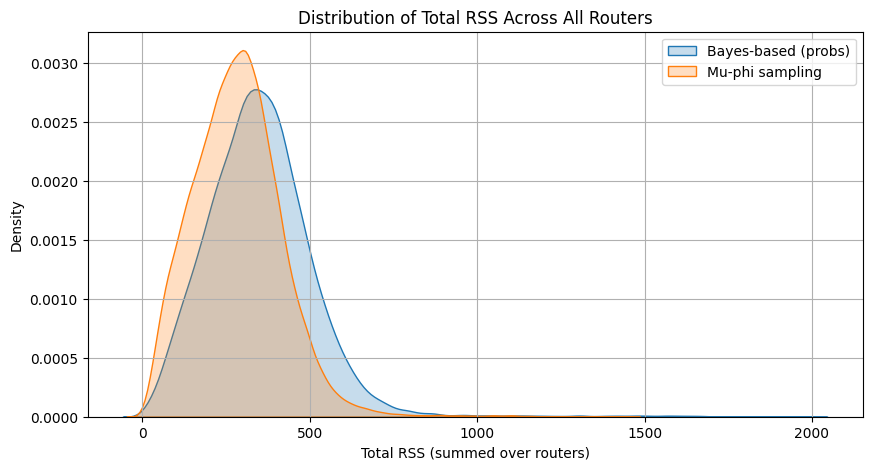

In [41]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df_probs[router_cols].sum(axis=1), label='Bayes-based (probs)', fill=True)
sns.kdeplot(df_sample[router_cols].sum(axis=1), label='Mu-phi sampling', fill=True)
plt.title('Distribution of Total RSS Across All Routers')
plt.xlabel('Total RSS (summed over routers)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
df_probs[router_cols].sum(axis=1)

0        561
1        276
2        326
3        442
4        315
        ... 
49995     95
49996    687
49997    249
49998    195
49999    443
Length: 50000, dtype: int64

In [43]:
df_sample[router_cols].sum(axis=1)

0        589.787478
1        113.375444
2        288.507453
3        286.468017
4        257.484329
            ...    
49995    143.042454
49996    325.842363
49997    162.523046
49998    243.823397
49999    423.574334
Length: 50000, dtype: float64

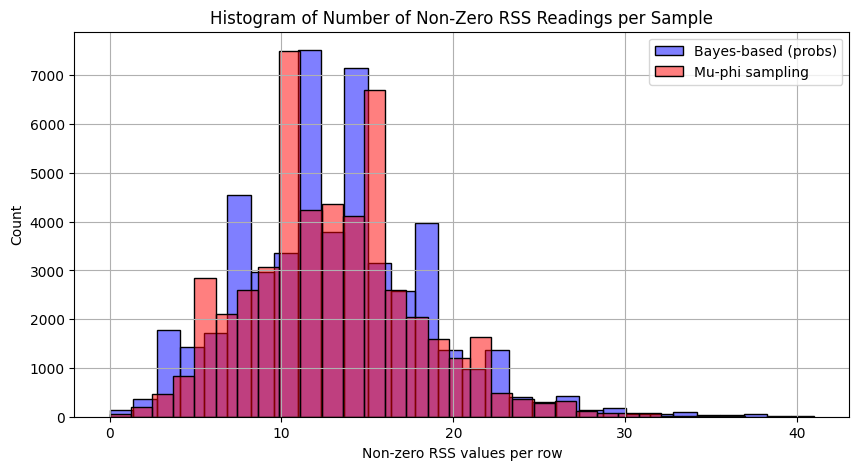

In [44]:
plt.figure(figsize=(10, 5))
nonzero_probs = (df_probs[router_cols] > 0).sum(axis=1)
nonzero_sample = (df_sample[router_cols] > 0).sum(axis=1)

sns.histplot(nonzero_probs, label='Bayes-based (probs)', color='blue', alpha=0.5, bins=30)
sns.histplot(nonzero_sample, label='Mu-phi sampling', color='red', alpha=0.5, bins=30)
plt.title('Histogram of Number of Non-Zero RSS Readings per Sample')
plt.xlabel('Non-zero RSS values per row')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

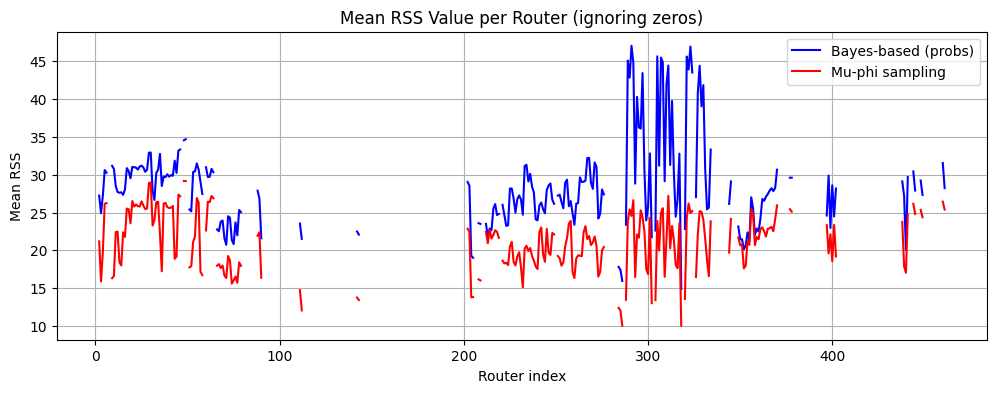

In [49]:
mean_probs = df_probs[router_cols].replace(0, np.nan).mean()
mean_sample = df_sample[router_cols].replace(0, np.nan).mean()

plt.figure(figsize=(12, 4))
plt.plot(mean_probs.values, label='Bayes-based (probs)', color='blue')
plt.plot(mean_sample.values, label='Mu-phi sampling', color='red')
plt.title('Mean RSS Value per Router (ignoring zeros)')
plt.xlabel('Router index')
plt.ylabel('Mean RSS')
plt.legend()
plt.grid(True)
plt.show()

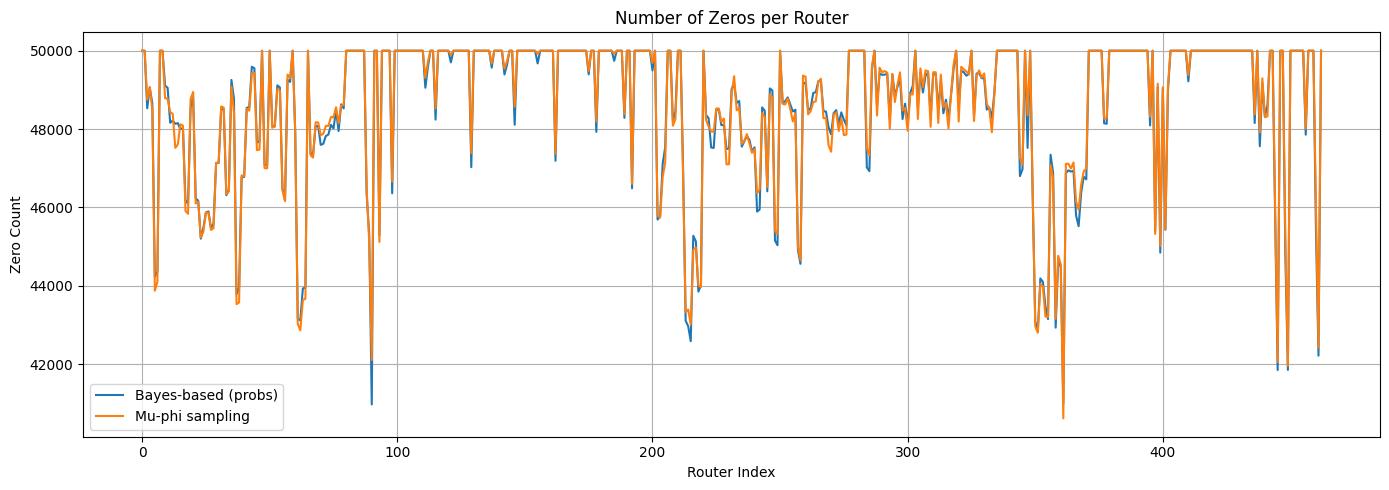

In [47]:
# Count zeros per router
zero_counts_probs = (df_probs[router_cols] == 0).sum()
zero_counts_sample = (df_sample[router_cols] == 0).sum()

# Plot
plt.figure(figsize=(14, 5))
sns.lineplot(x=range(len(router_cols)), y=zero_counts_probs.values, label='Bayes-based (probs)')
sns.lineplot(x=range(len(router_cols)), y=zero_counts_sample.values, label='Mu-phi sampling')
plt.title("Number of Zeros per Router")
plt.xlabel("Router Index")
plt.ylabel("Zero Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
sum(np.random.binomial(1, 0.9, 20000))/20000.

0.8952

In [53]:
rng.binomial(1, 0.9)

1

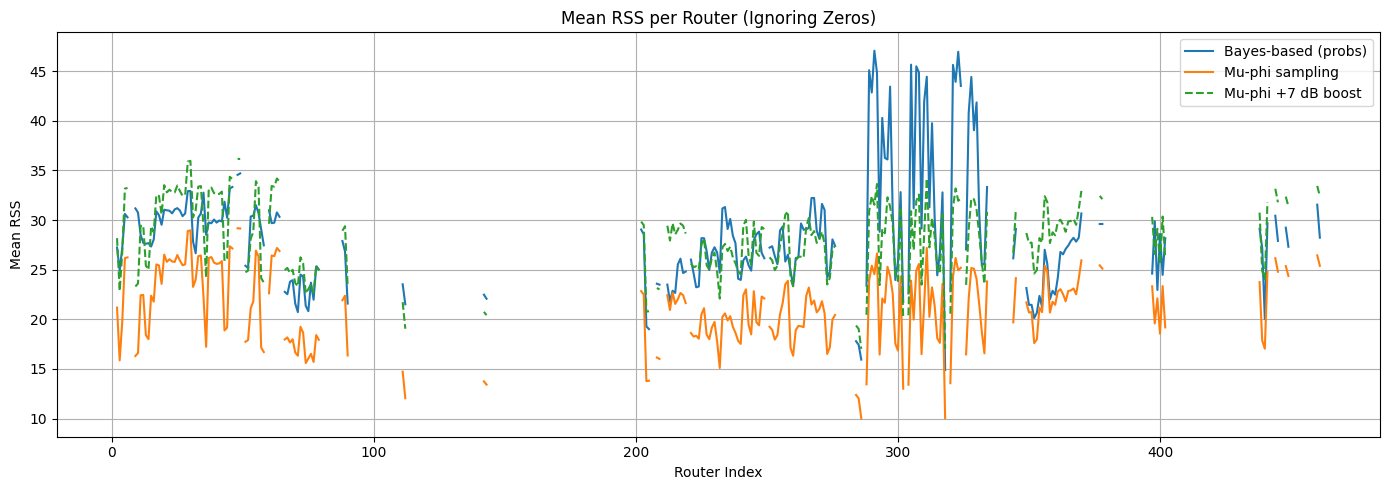

In [55]:
df_sample_boosted = df_sample.copy()
df_sample_boosted[router_cols] = df_sample_boosted[router_cols].applymap(lambda x: min(x + 7, 105) if x > 0 else 0)

# Plot mean power comparison
mean_probs = df_probs[router_cols].replace(0, np.nan).mean()
mean_sample = df_sample[router_cols].replace(0, np.nan).mean()
mean_boosted = df_sample_boosted[router_cols].replace(0, np.nan).mean()

plt.figure(figsize=(14, 5))
plt.plot(mean_probs.values, label='Bayes-based (probs)')
plt.plot(mean_sample.values, label='Mu-phi sampling')
plt.plot(mean_boosted.values, label='Mu-phi +7 dB boost', linestyle='--')
plt.title("Mean RSS per Router (Ignoring Zeros)")
plt.xlabel("Router Index")
plt.ylabel("Mean RSS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

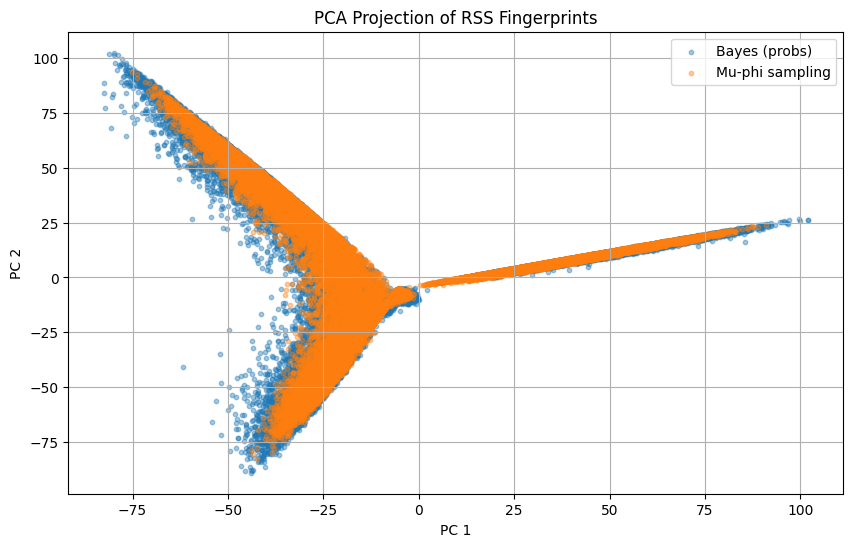

In [46]:
# Replace NaN with 0 before projecting
X_probs = df_probs[router_cols].fillna(0).values
X_sample = df_sample[router_cols].fillna(0).values

# PCA
pca = PCA(n_components=2)
X_pca_probs = pca.fit_transform(X_probs)
X_pca_sample = pca.transform(X_sample)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca_probs[:, 0], X_pca_probs[:, 1], alpha=0.4, label='Bayes (probs)', s=10)
plt.scatter(X_pca_sample[:, 0], X_pca_sample[:, 1], alpha=0.4, label='Mu-phi sampling', s=10)
plt.title('PCA Projection of RSS Fingerprints')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.grid(True)
plt.show()

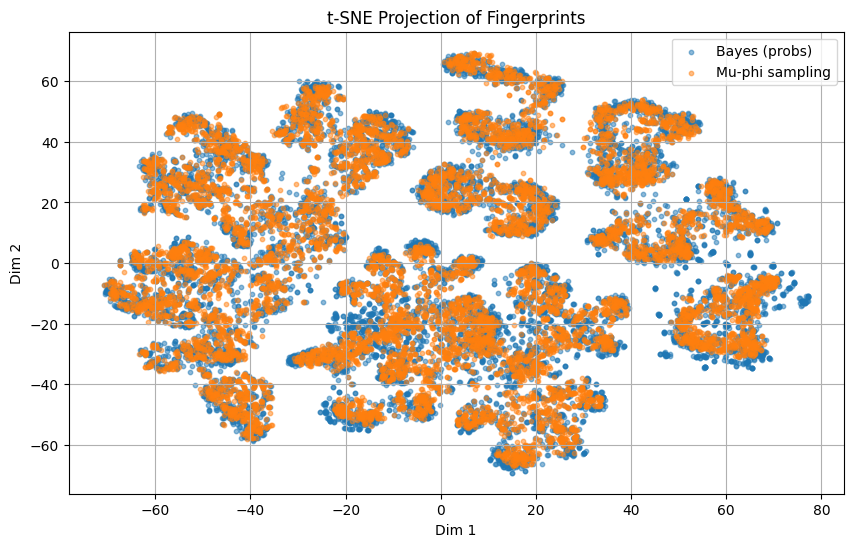

In [24]:
# t-SNE for local structure (slower)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_combined = np.vstack([X_probs, X_sample])
X_tsne = tsne.fit_transform(X_combined)

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:len(X_probs), 0], X_tsne[:len(X_probs), 1], label='Bayes (probs)', alpha=0.5, s=10)
plt.scatter(X_tsne[len(X_probs):, 0], X_tsne[len(X_probs):, 1], label='Mu-phi sampling', alpha=0.5, s=10)
plt.title('t-SNE Projection of Fingerprints')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
def print_stats(df, label):
    nonzeros = (df[router_cols] > 0).sum(axis=1)
    print(f"\n[{label}]")
    print("Mean non-zero routers per sample:", nonzeros.mean())
    print("Mean RSS (non-zero only):", df[router_cols].replace(0, np.nan).mean().mean())
    print("Std Dev of RSS (non-zero only):", df[router_cols].replace(0, np.nan).std().mean())

print_stats(df_probs, "Bayes-based (probs)")
print_stats(df_sample, "Mu-phi sampling")


[Bayes-based (probs)]
Mean non-zero routers per sample: 13.1448
Mean RSS (non-zero only): 28.141557590968258
Std Dev of RSS (non-zero only): 12.229626223073659

[Mu-phi sampling]
Mean non-zero routers per sample: 13.0246
Mean RSS (non-zero only): 20.92561762527984
Std Dev of RSS (non-zero only): 10.870131138525615
